# Get data and imports

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
sns.set()
sns.set_style("darkgrid", {'image.cmap': u'plasma'})

np.random.seed(11111111)

In [88]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File 'sp500sub.csv' already there; not retrieving.



In [89]:
# read the data
df = pd.read_csv('sp500sub.csv', index_col=0, parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [90]:
df.Name.unique() # get the unique names of the stocks in the data set

array(['INCY', 'GILD', 'DXC', 'AFL', 'XYL', 'ARE', 'AMD', 'WYNN', 'IBM',
       'ATVI', 'AES', 'GPC', 'PRU', 'HST', 'WMB', 'GOOG', 'SRE', 'HSIC',
       'UNP', 'UPS', 'K', 'LYB', 'MDT', 'COF', 'HAS', 'CSX', 'GT', 'SYF',
       'EBAY', 'KSS', 'AJG', 'JWN', 'SBUX', 'IT', 'PH', 'DVN', 'MMM',
       'SPG', 'AKAM', 'IP', 'CPB', 'KMI', 'AAPL', 'NEM', 'KMX', 'TSCO',
       'SYY', 'VNO', 'NWS', 'NBL', 'ACN', 'APH', 'PDCO', 'WLTW', 'FIS',
       'URI', 'CBOE', 'FISV', 'BA', 'UAA', 'CVS', 'WU', 'SLB', 'AIV',
       'VLO', 'MU', 'CAH', 'AZO', 'CCI', 'ZTS', 'MCO', 'ALLE', 'RHI',
       'UAL', 'IR', 'CB', 'VMC', 'GD', 'AAP', 'NEE', 'ABT', 'WFC', 'DIS',
       'SNA', 'MAR', 'JPM', 'CLX', 'KIM', 'SCG', 'HBI', 'ABBV', 'RSG',
       'ETR', 'ADBE', 'COO', 'HLT', 'INTU', 'SLG', 'GWW', 'COG', 'CBS',
       'FB', 'CMS', 'MDLZ'], dtype=object)

In [91]:
# crete a new dataframe with the closing prices of the stocks to put all the data side by side in one dataframe
names = ['GOOG', 'SBUX', 'KSS', 'NEM']
# look at the returns only over a 6-months period
all_dates = df.index.unique().sort_values()
start_date = all_dates.get_loc('2014-01-02')
end_date = all_dates.get_loc('2014-06-30')
dates = all_dates[start_date:end_date+1]
del start_date, end_date, all_dates
# get the close prices of the stocks
close_prices = pd.DataFrame(index=dates)
tmp1 = df.loc[dates]
for name in names:
    df_temp = tmp1[tmp1.Name == name]
    df_temp = df_temp[['Close']]
    close_prices = close_prices.join(df_temp)
    close_prices = close_prices.rename(columns={'Close': name})

In [92]:
close_prices.head()

,GOOG,SBUX,KSS,NEM
Date,,,,
2014-01-02,554.481689,38.584999,56.990002,23.959999
2014-01-03,550.436829,38.474998,56.860001,23.920000
2014-01-06,556.573853,38.084999,56.040001,24.080000
2014-01-07,567.303589,38.605000,56.099998,23.950001
2014-01-08,568.484192,39.014999,55.180000,23.400000


In [93]:
# Check for nan values and forward fill them
if close_prices.isnull().values.any():
    print('There are nan values in the data set')
    close_prices = close_prices.fillna(method='ffill')
    close_prices = close_prices.fillna(method='bfill')
else:
    print('There are no nan values in the data set')

There are no nan values in the data set


In [94]:
# Create returns dataframe
returns = pd.DataFrame(index=dates[1:])
for name in names:
    returns[name] = close_prices[name].pct_change()[1:] * 100 # get the returns of the stocks in percentage

In [95]:
returns.head()

,GOOG,SBUX,KSS,NEM
Date,,,,
2014-01-03,-0.729485,-0.285086,-0.228112,-0.166941
2014-01-06,1.114937,-1.013644,-1.442138,0.668896
2014-01-07,1.927819,1.365368,0.107062,-0.539864
2014-01-08,0.208108,1.062038,-1.639925,-2.296456
2014-01-09,-0.962997,-0.551071,0.688657,-0.854696


In [96]:
mean_return = returns.mean() # get the mean returns of the stocks in the portfolio (in percentage) over the 6-months period
mean_return

GOOG    0.038691
SBUX    0.009955
KSS    -0.053793
NEM     0.072932
dtype: float64

In [97]:
# Calculate the covariance matrix of the returns
cov_matrix = returns.cov()
cov_matrix = cov_matrix.values # convert the covariance matrix to a numpy array to be able to use it in the monte carlo simulation 
cov_matrix

array([[ 2.20656478,  0.832469  ,  0.77177157, -0.03360028],
       [ 0.832469  ,  1.55840635,  0.71458628,  0.37444817],
       [ 0.77177157,  0.71458628,  2.02585403,  0.18030838],
       [-0.03360028,  0.37444817,  0.18030838,  4.81510393]])

# Run Monte Carlo Simulation allowing short selling

In [98]:
def plot_portfolios(returns, risks):
    """Plot the returns and risks of the portfolios.
    Draw a scatter plot of the returns and the risks of the portfolios
    The color of the points is determined by the density of the points
    """
    plt.figure(figsize=(10, 6))
    xy = np.vstack([risks,returns])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    risks, returns, z = risks[idx], returns[idx], z[idx]
    plt.scatter(risks, returns, c=z, marker='o')
    plt.xlabel('Risk')
    plt.ylabel('Return')

Text(0.5, 1.0, 'Markowitz Bullet')

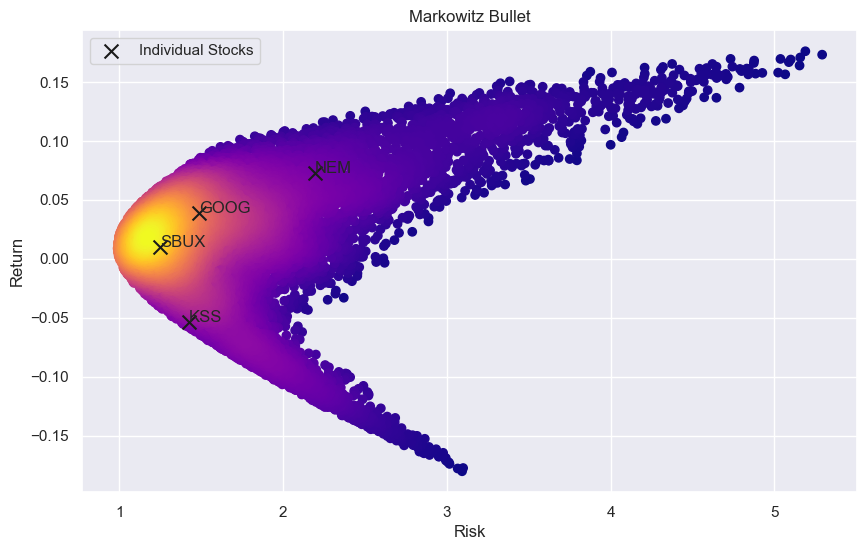

In [99]:
N = 10000 # number of simulations
D = len(names) # number of stocks in the portfolio
returns_array = np.zeros(N) # create an array to store the average returns of the stocks in the portfolio for each simulation
risks_array = np.zeros(N) # create an array to store the average risks of the stocks in the portfolio for each simulation
random_weights = [] # create an array to store the random weights of the stocks in the portfolio for each simulation
for i in range(N):
    rand_range = 1 # set the range of the random numbers to be between 0 and 1
    w = np.random.random(D) * rand_range - rand_range/2 # generate random weights for the stocks in the portfolio (between -0.5 and 0.5)
    w[-1] = 1 - np.sum(w[:-1]) # make sure that the sum of the weights is 1
    np.random.shuffle(w) # shuffle the weights to make sure that the weights are not in the same order as the stocks in the portfolio 
    random_weights.append(w) # append the weights to the array
    returns_array[i] = np.dot(w, mean_return) # calculate the average returns of the stocks in the portfolio for each simulation
    risks_array[i] = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) # calculate the average risks of the stocks in the portfolio for each simulation

single_asset_returns = np.zeros(D) # create an array to store the average returns of the stocks in the portfolio for each simulation
single_asset_risks = np.zeros(D) # create an array to store the average risks of the stocks in the portfolio for each simulation

for i in range(D):
    single_asset_returns[i] = mean_return[i]
    single_asset_risks[i] = np.sqrt(cov_matrix[i,i])

plot_portfolios(returns_array, risks_array)
plt.scatter(single_asset_risks, single_asset_returns, c='k', marker='x', s=100, label='Individual Stocks')
# add labels to the points
for i in range(D):
    plt.annotate(names[i], (single_asset_risks[i], single_asset_returns[i]))
plt.legend()
plt.title('Markowitz Bullet')

# Finding Maximum and Minimum with a Linear Program (LP)

In [100]:
from scipy.optimize import linprog

In [101]:
D = len(names) # number of stocks in the portfolio
A_eq = np.ones((1, D)) # create the equality constraint matrix
b_eq = np.ones(1) # create the equality constraint vector
bounds = tuple((-0.5, None) for x in range(D)) # set the bounds of the weights to be between -0.5 and no upper bound to maintain consistency with the random weights generated in the monte carlo simulation
print(A_eq, b_eq, bounds)

[[1. 1. 1. 1.]] [1.] ((-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None))


In [102]:
# minimize the risk of the portfolio
res = linprog(mean_return, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
min_return = res.fun
res

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -0.1952725235483168
              x: [-5.000e-01 -5.000e-01  2.500e+00 -5.000e-01]
            nit: 0
          lower:  residual: [ 0.000e+00  0.000e+00  3.000e+00  0.000e+00]
                 marginals: [ 9.248e-02  6.375e-02  0.000e+00  1.267e-01]
          upper:  residual: [       inf        inf        inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [-5.379e-02]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

In [103]:
res = linprog(-mean_return, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
max_return = -res.fun
res

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -0.18490322425695138
              x: [-5.000e-01 -5.000e-01 -5.000e-01  2.500e+00]
            nit: 0
          lower:  residual: [ 0.000e+00  0.000e+00  0.000e+00  3.000e+00]
                 marginals: [ 3.424e-02  6.298e-02  1.267e-01  0.000e+00]
          upper:  residual: [       inf        inf        inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [-7.293e-02]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

In [104]:
print(min_return, max_return)

-0.1952725235483168 0.18490322425695138


# Mean-Variance Optimization & Efficient Frontier

In [105]:
from scipy.optimize import minimize

In [106]:
N = 100 # number of steps
target_returns = np.linspace(min_return, max_return, N) # create an array of target returns to optimize the weights of the stocks in the portfolio for

In [107]:
def get_portofolio_variance(weights, cov_matrix):
    """Calculate the variance of the portfolio.
    Calculate the variance of the portfolio given the weights of the stocks in the portfolio and the covariance matrix of the returns
    
    Parameters
    ----------
    weights : numpy array
        The weights of the stocks in the portfolio
    cov_matrix : numpy array
        The covariance matrix of the returns of the stocks in the portfolio

    Returns
    -------
    float
        The variance of the portfolio
    """
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def target_return_constraint(weights, target):
    """Calculate the difference between the target return and the actual return of the portfolio.
    Calculate the difference between the target return and the actual return of the portfolio given the weights of the stocks in the portfolio and the mean returns of the stocks in the portfolio
    This is to be used as an equality constraint in the optimization. 

    Parameters
    ----------
    weights : numpy array
        The weights of the stocks in the portfolio
    target : float
        The target return of the portfolio

    Returns
    -------
    float
        The difference between the target return and the actual return of the portfolio
    """
    return np.dot(weights, mean_return) - target

def portofolio_constraint(weights):
    """Calculate the difference between the sum of the weights and 1.
    Calculate the difference between the sum of the weights and 1 to make sure that the sum of the weights is 1
    This is to be used as an equality constraint in the optimization. 

    Parameters
    ----------
    weights : numpy array
        The weights of the stocks in the portfolio

    Returns
    -------
    float
        The difference between the sum of the weights and 1
    """
    return np.sum(weights) - 1

constraints = [
    {'type': 'eq', 
     'fun': target_return_constraint,
     'args': [target_returns[0]],
     },
    {'type': 'eq',
      'fun': portofolio_constraint,
     }
]

In [108]:
# Generate efficient frontier by running through all the target returns
optimizer_risks = []
for target in target_returns:
    constraints[0]['args'] = [target]
    res = minimize(fun=get_portofolio_variance, 
               x0 = np.ones(D)/D,
               args=(cov_matrix,), 
               method='SLSQP', 
               constraints=constraints,
               bounds=bounds,
               )
    optimizer_risks.append(np.sqrt(res.fun))

    if res.status != 0:
        print(res.message) # print the error message if the optimization fails


Text(0.5, 1.0, 'Markowitz Bullet')

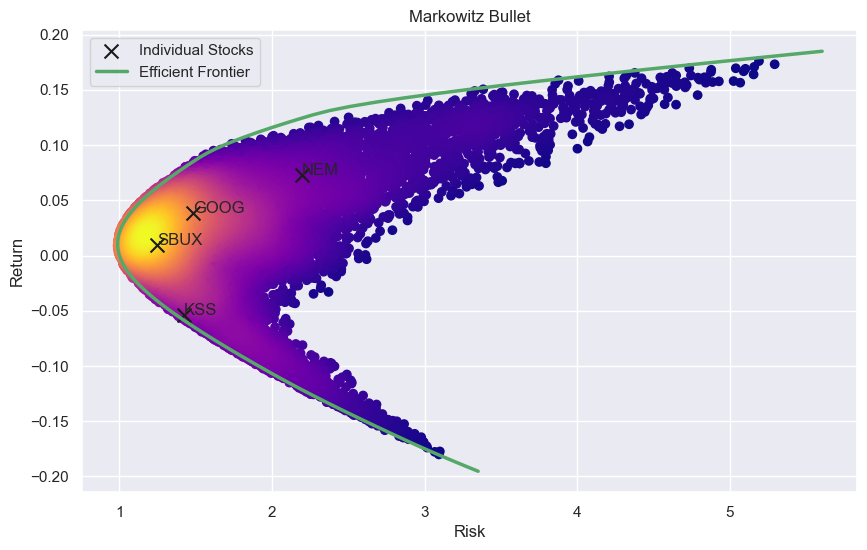

In [109]:
plot_portfolios(returns_array, risks_array)
plt.scatter(single_asset_risks, single_asset_returns, c='k', marker='x', s=100, label='Individual Stocks')
plt.plot(optimizer_risks, target_returns, c='g', linewidth=2.5, label='Efficient Frontier')
# add labels to the points
for i in range(D):
    plt.annotate(names[i], (single_asset_risks[i], single_asset_returns[i]))
plt.legend()
plt.title('Markowitz Bullet')

In [110]:
target_returns

array([-0.19527252, -0.19143236, -0.18759221, -0.18375205, -0.17991189,
       -0.17607173, -0.17223157, -0.16839141, -0.16455125, -0.16071109,
       -0.15687093, -0.15303077, -0.14919061, -0.14535046, -0.1415103 ,
       -0.13767014, -0.13382998, -0.12998982, -0.12614966, -0.1223095 ,
       -0.11846934, -0.11462918, -0.11078902, -0.10694886, -0.10310871,
       -0.09926855, -0.09542839, -0.09158823, -0.08774807, -0.08390791,
       -0.08006775, -0.07622759, -0.07238743, -0.06854727, -0.06470712,
       -0.06086696, -0.0570268 , -0.05318664, -0.04934648, -0.04550632,
       -0.04166616, -0.037826  , -0.03398584, -0.03014568, -0.02630552,
       -0.02246537, -0.01862521, -0.01478505, -0.01094489, -0.00710473,
       -0.00326457,  0.00057559,  0.00441575,  0.00825591,  0.01209607,
        0.01593623,  0.01977638,  0.02361654,  0.0274567 ,  0.03129686,
        0.03513702,  0.03897718,  0.04281734,  0.0466575 ,  0.05049766,
        0.05433782,  0.05817797,  0.06201813,  0.06585829,  0.06

Text(0.5, 1.0, 'Markowitz Bullet')

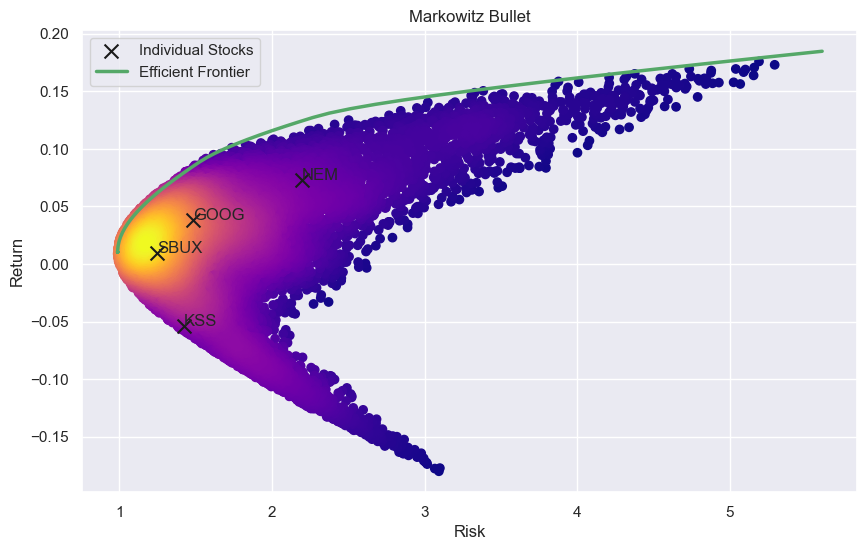

In [111]:
# We can repeat the above, but now constrain the return to be positive
# This will give us the maximum return for a given risk
constraints = [
    {'type': 'ineq',
        'fun': target_return_constraint,
        'args': [target_returns[0]],
    },
    {'type': 'eq',
        'fun': portofolio_constraint,
    }
]

# Generate efficient frontier by running through all the target returns
optimizer_risks = []
optimized_returns = []
for target in target_returns:
    constraints[0]['args'] = [target]
    res = minimize(fun=get_portofolio_variance, 
               x0 = np.ones(D)/D,
               args=(cov_matrix,), 
               method='SLSQP', 
               constraints=constraints,
               bounds=bounds,
               )
    optimizer_risks.append(np.sqrt(res.fun))
    optimized_returns.append(np.dot(res.x, mean_return))

    if res.status != 0:
        print(res.message) # print the error message if the optimization fails

plot_portfolios(returns_array, risks_array)
plt.scatter(single_asset_risks, single_asset_returns, c='k', marker='x', s=100, label='Individual Stocks')
plt.plot(optimizer_risks, optimized_returns, c='g', linewidth=2.5, label='Efficient Frontier')
# add labels to the points
for i in range(D):
    plt.annotate(names[i], (single_asset_risks[i], single_asset_returns[i]))
plt.legend()
plt.title('Markowitz Bullet')


In [112]:
target_returns

array([-0.19527252, -0.19143236, -0.18759221, -0.18375205, -0.17991189,
       -0.17607173, -0.17223157, -0.16839141, -0.16455125, -0.16071109,
       -0.15687093, -0.15303077, -0.14919061, -0.14535046, -0.1415103 ,
       -0.13767014, -0.13382998, -0.12998982, -0.12614966, -0.1223095 ,
       -0.11846934, -0.11462918, -0.11078902, -0.10694886, -0.10310871,
       -0.09926855, -0.09542839, -0.09158823, -0.08774807, -0.08390791,
       -0.08006775, -0.07622759, -0.07238743, -0.06854727, -0.06470712,
       -0.06086696, -0.0570268 , -0.05318664, -0.04934648, -0.04550632,
       -0.04166616, -0.037826  , -0.03398584, -0.03014568, -0.02630552,
       -0.02246537, -0.01862521, -0.01478505, -0.01094489, -0.00710473,
       -0.00326457,  0.00057559,  0.00441575,  0.00825591,  0.01209607,
        0.01593623,  0.01977638,  0.02361654,  0.0274567 ,  0.03129686,
        0.03513702,  0.03897718,  0.04281734,  0.0466575 ,  0.05049766,
        0.05433782,  0.05817797,  0.06201813,  0.06585829,  0.06

# Global Minimum Variance

Text(0.5, 1.0, 'Markowitz Bullet')

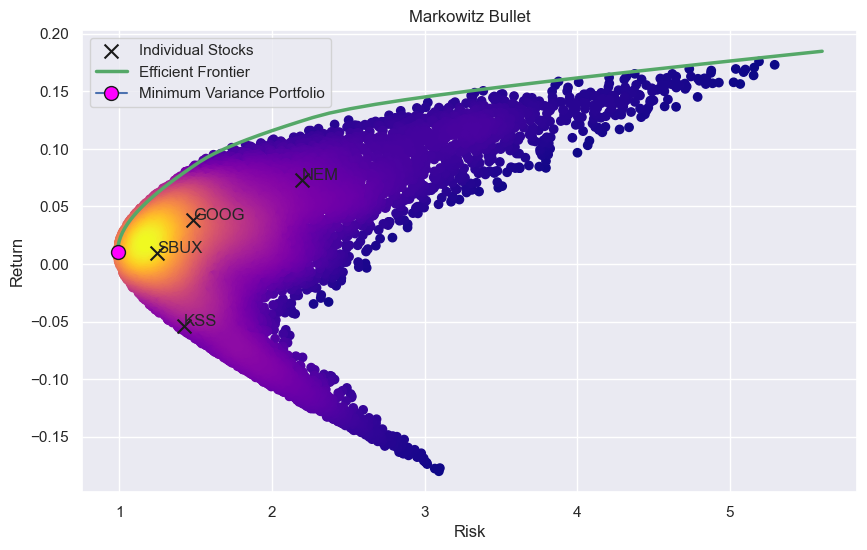

In [115]:
# Get the min variance portofolio whhile limiting the magnitde of the weights

constraints = {
    'type': 'eq',
    'fun': portofolio_constraint,
}

res = minimize(fun=get_portofolio_variance,
                x0 = np.ones(D)/D,
                args=(cov_matrix,),
                method='SLSQP',
                constraints=constraints,
                bounds=bounds,
                )

gmv_risk = np.sqrt(res.fun)
gmv_return = np.dot(res.x, mean_return)

plot_portfolios(returns_array, risks_array)
plt.scatter(single_asset_risks, single_asset_returns, c='k', marker='x', s=100, label='Individual Stocks')
plt.plot(optimizer_risks, optimized_returns, c='g', linewidth=2.5, label='Efficient Frontier')
plt.plot(gmv_risk, gmv_return, markerfacecolor='magenta', markeredgecolor='k', marker='o', markersize=10, label='Minimum Variance Portfolio')
# add labels to the points
for i in range(D):
    plt.annotate(names[i], (single_asset_risks[i], single_asset_returns[i]))
plt.legend()
plt.title('Markowitz Bullet')

# Sharpe Ratio

In [117]:
risk_free_rate = 0.03 / 252 # 3% annualized daily rate of return (risk free rate) (SOURCE: https://fred.stlouisfed.org/series/TB3MS)

def neg_sharpe_ratio(weights, risk_free_rate, mean_returns, cov_matrix):
    """Calculate the negative of the sharpe ratio.
    Calculate the negative of the sharpe ratio given the weights of the stocks in the portfolio, the risk free rate, the mean returns of the stocks in the portfolio and the covariance matrix of the returns of the stocks in the portfolio
    
    Parameters
    ----------
    weights : numpy array
        The weights of the stocks in the portfolio
    risk_free_rate : float
        The risk free rate of return
    mean_returns : numpy array
        The mean returns of the stocks in the portfolio
    cov_matrix : numpy array
        The covariance matrix of the returns of the stocks in the portfolio

    Returns
    -------
    float
        The negative of the sharpe ratio
    """
    p_var = get_portofolio_variance(weights, cov_matrix)  # portfolio variance 
    p_ret = np.dot(weights, mean_returns) # portfolio return 
    return -(p_ret - risk_free_rate) / np.sqrt(p_var)

In [118]:
constraints = {
    'type': 'eq',
    'fun': portofolio_constraint,
}

res = minimize(fun=neg_sharpe_ratio,
                x0 = np.ones(D)/D,
                args=(risk_free_rate, mean_return, cov_matrix),
                method='SLSQP',
                constraints=constraints,
                bounds=bounds,
                )
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.05920759737914635
       x: [ 8.422e-01  1.183e-01 -5.000e-01  5.394e-01]
     nit: 16
     jac: [ 9.372e-03  9.290e-03  2.812e-02  9.263e-03]
    nfev: 80
    njev: 16

In [119]:
best_sr, best_sr_weights = -res.fun, res.x

In [120]:
# Use the Monte Carlo approach to find the optimum portofolio instead of calculating the analytical solution
mc_best_w = None
mc_best_sr = float('-inf')

for i, (risk, ret) in enumerate(zip(risks_array, returns_array)):
    sr = (ret - risk_free_rate) / risk
    if sr > mc_best_sr:
        mc_best_sr = sr
        mc_best_w = random_weights[i]

print(mc_best_w, mc_best_sr)

[ 0.83672968  0.15746572 -0.47834685  0.48415146] 0.05865240714422086


Text(0.5, 1.0, 'Markowitz Bullet')

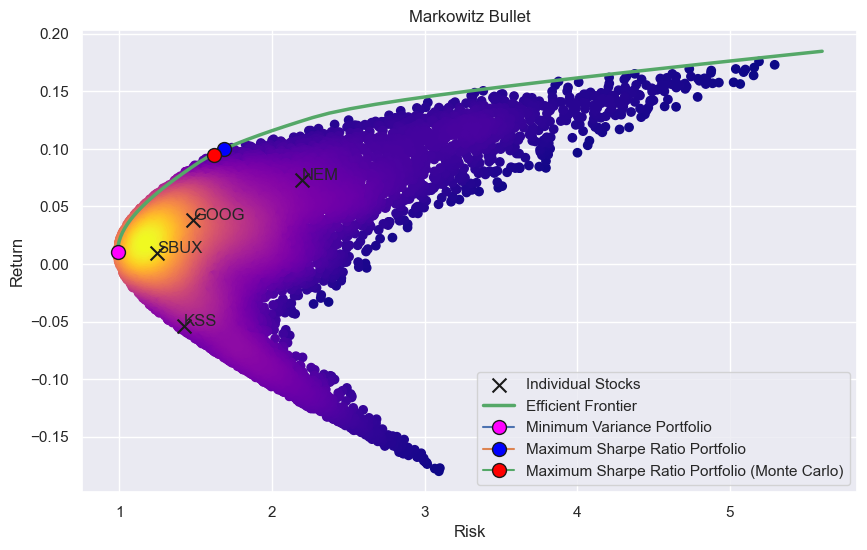

In [121]:
plot_portfolios(returns_array, risks_array)
plt.scatter(single_asset_risks, single_asset_returns, c='k', marker='x', s=100, label='Individual Stocks')
plt.plot(optimizer_risks, optimized_returns, c='g', linewidth=2.5, label='Efficient Frontier')
plt.plot(gmv_risk, gmv_return, markerfacecolor='magenta', markeredgecolor='k', marker='o', markersize=10, label='Minimum Variance Portfolio')

opt_risk = np.sqrt(get_portofolio_variance(best_sr_weights, cov_matrix))
opt_return = np.dot(best_sr_weights, mean_return)
plt.plot(opt_risk, opt_return, markerfacecolor='blue', markeredgecolor='k', marker='o', markersize=10, label='Maximum Sharpe Ratio Portfolio')

mc_opt_risk = np.sqrt(get_portofolio_variance(mc_best_w, cov_matrix))
mc_opt_return = np.dot(mc_best_w, mean_return)
plt.plot(mc_opt_risk, mc_opt_return, markerfacecolor='red', markeredgecolor='k', marker='o', markersize=10, label='Maximum Sharpe Ratio Portfolio (Monte Carlo)')

# add labels to the points
for i in range(D):
    plt.annotate(names[i], (single_asset_risks[i], single_asset_returns[i]))
plt.legend()
plt.title('Markowitz Bullet')

# Risk-Free Asset and Tangency Portofolio


Text(0.5, 1.0, 'Markowitz Bullet')

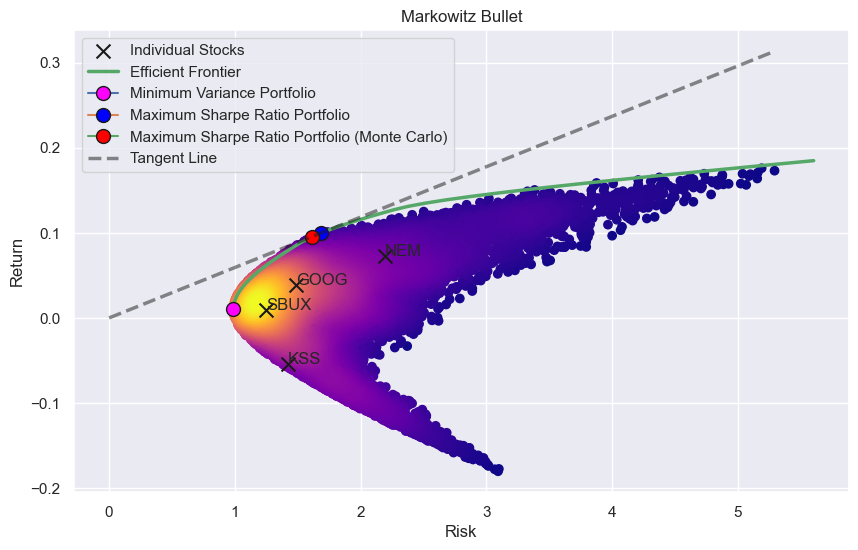

In [130]:
# Find the tangency portofolio
opt_risk = np.sqrt(get_portofolio_variance(best_sr_weights, cov_matrix))
opt_return = np.dot(best_sr_weights, mean_return)

# Get the tangent line
# x1 = 0
# y1 = risk_free_rate
# x2 = opt_risk
# y2 = opt_return

# Get the tanget line
x = np.linspace(0, max(risks_array), 100)
y = risk_free_rate + (opt_return - risk_free_rate) / opt_risk * x

plot_portfolios(returns_array, risks_array)
plt.scatter(single_asset_risks, single_asset_returns, c='k', marker='x', s=100, label='Individual Stocks')
plt.plot(optimizer_risks, optimized_returns, c='g', linewidth=2.5, label='Efficient Frontier')
plt.plot(gmv_risk, gmv_return, markerfacecolor='magenta', markeredgecolor='k', marker='o', markersize=10, label='Minimum Variance Portfolio')

opt_risk = np.sqrt(get_portofolio_variance(best_sr_weights, cov_matrix))
opt_return = np.dot(best_sr_weights, mean_return)
plt.plot(opt_risk, opt_return, markerfacecolor='blue', markeredgecolor='k', marker='o', markersize=10, label='Maximum Sharpe Ratio Portfolio')

mc_opt_risk = np.sqrt(get_portofolio_variance(mc_best_w, cov_matrix))
mc_opt_return = np.dot(mc_best_w, mean_return)
plt.plot(mc_opt_risk, mc_opt_return, markerfacecolor='red', markeredgecolor='k', marker='o', markersize=10, label='Maximum Sharpe Ratio Portfolio (Monte Carlo)')

# plt.plot([x1, x2], [y1, y2], '--r', linewidth=2.5, label='Tangent Line')
plt.plot(x, y, '--k', linewidth=2.5, label='Tangent Line', alpha=0.5)

# add labels to the points
for i in range(D):
    plt.annotate(names[i], (single_asset_risks[i], single_asset_returns[i]))
plt.legend()
plt.title('Markowitz Bullet')